# Gaussian Process Regression/Classification su Grafi

## Introduzione
Gli algoritmi di Gaussian Process Regression and Gaussian Process Classification, che qui qui presentiamo in un'applicazione su grafi, sono algoritmi di learning Bayesiano:
a differenza degli algoritmi di learning "classici", che 
1. risolvono un problema di ottimizzazione convessa per identificare un modello di "best fit" per spiegare i dati e poi
2. utilizzano tale modello per effettuare predizioni su punti di input futuri

gli algoritmi Bayesiani non cercano il modello di "best fit" ma calcolano una distribuzione a posteriori sui modelli condizionata alle misure effettuate.
La differenza di approccio permette agli algoritmi Bayesiani di utilizzare queste distribuzioni, oltre che per trovare un modello che spieghi i dati, anche di stimare l'incertezza legata alle previsioni del modello stesso.

Gli algoritmi che introduciamo sono algoritmi di regressione ( l'obiettivo è imparare un mapping di un certo spazio di input $ A \in \mathbb{R}^n $ ad uno spazio $ B \in \mathbb{R}$ di target a valori reali ) e di classificazione ( concettualmente non troppo dissimile, se non per il fatto che lo spazio di output rappresenta una probabilità e i valori di training sono label binarie ).

## Gaussiane Multivariate
Per cominciare partiamo dalla definizione di **Gaussiana Multivariata** e di alcune sue importanti proprietà:

Una variabile vettoriale stocastica $ x \in \mathbb{R}^n $ è detta  avere una **distribuzione normale (Gaussiana) multivariata** con media $ \mu \in \mathbb{R}^n $ e matrice di covarianza $ \Sigma \in \mathbb{S}^{n}_{++} $ ( $ \mathbb{S}^{n}_{++} $ è lo spazio delle matrici definite positive $ n \times n $ ) se 

$ \begin{equation}
p(x;\mu,\Sigma) = \frac{1}{(2 \pi )^{n/2} \left|{\Sigma}\right|} e^{-\frac{1}{2} (x - \mu)^{T} \Sigma^{-1} (x-\mu)}
\end{equation}$

scriviamo in forma abbreviata $ \mathcal{N}(\mu, \Sigma) $

Considerando un vettore random $ x \in \mathbb{R}^n $ con $ x \sim \mathcal{N}(\mu, \Sigma)$, ipotizziamo che le variabili in $ x $ siano divise in due set: 
* $x_A = [x_1, \ldots, x_r]^T \in \mathbb{R}^r$
* $x_B = [x_{r+1}, \ldots,  x_n]^T \in \mathbb{R}^{n-r}$

in modo tale da avere 
* $x = \begin{bmatrix} {x_A \\ x_B }\end{bmatrix} $
* $\mu = \begin{bmatrix} {\mu_A \\ \mu_B }\end{bmatrix} $
* $\Sigma = \begin{bmatrix} \Sigma_{AA} & \Sigma_{AB}\\ \Sigma_{BA} & \Sigma_{BB}\end{bmatrix} $

Per il fatto che $\Sigma = E \left[ (x-\mu)(x-\mu)^T \right] $ abbiamo che $ \Sigma_{AB} = \Sigma_{BA}^T$. Valgono le seguenti proprietà:

1. ** Normalizzazione ** : $ \int_x{p(x;\mu,\Sigma)dx} = 1$

2. ** Marginalizzazione ** : Le densità di probabilità marginali 
    * $p(x_A) =  \int_{x_B}{p(x_a, x_b;\mu,\Sigma)dx_B}$
    * $p(x_B) =  \int_{x_A}{p(x_a, x_b;\mu,\Sigma)dx_A}$
    
    sono Gaussiane:
    * $ x_A \sim \mathcal{N}(\mu_A, \Sigma_{AA}) $
    * $ x_B \sim \mathcal{N}(\mu_B, \Sigma_{BB}) $
    
3. ** Distribuzioni Condizionali ** : Le densità di probabilità condizionali
    * $p(x_A | x_B) =  \frac{p(x_a, x_b;\mu,\Sigma)}{\int_{x_A}{p(x_a, x_b;\mu,\Sigma)dx_B}dx_A}$
    * $p(x_B | x_A) =  \frac{p(x_a, x_b;\mu,\Sigma)}{\int_{x_B}{p(x_a, x_b;\mu,\Sigma)dx_B}dx_A}$
    
    sono anch'esse Gaussiane, con medie e varianze date da: 
    
   * $ x_A | x_B \sim \mathcal{N}(\mu_A + \Sigma_{AB}\Sigma_{BB}^{-1}(x_B - \mu_B), \Sigma_{AB}\Sigma_{BB}^{-1}\Sigma_{BA})$
   * $ x_B | x_A \sim \mathcal{N}(\mu_B + \Sigma_{BA}\Sigma_{AA}^{-1}(x_A - \mu_A), \Sigma_{BA}\Sigma_{AA}^{-1}\Sigma_{AB})$

4. ** Somma di Distribuzioni ** : La somma di variabili indipendenti $ y \sim \mathcal{N}(\mu, \Sigma) $ e $ z \sim \mathcal{N}(\mu', \Sigma') $ è anch'è essa Gaussiana: $ y + z \sim \mathcal{N}(\mu + \mu', \Sigma + \Sigma') $

## Distribuzioni di probabilità su funzioni a dominio finito

Sia $ \mathcal{X} = \{ x_1 \ldots x_m \} $ un set finito di elementi, ora prendiamo il set $ \mathcal{H} $ di possibili funzioni che mappino $\mathcal{X} \rightarrow \mathbb{R} $, dal momento che il dominio di una qualsiasi $ f ( \cdot ) \in \mathcal{H}$ è composto di *m* elementi, possiamo rappresentare  $ f ( \cdot )$ come un vettore *m*-dimensionale $\vec{f} = \left[ f(x_1), f(x_2), \ldots, f(x_m) \right]^T$. Possiamo ipotizzare una distribuzione di probabilità sulle funzioni $f(\cdot) \in \mathcal{H}$ usando la corrispondenza biunivoca tra le $f(\cdot) \in \mathcal{H}$ e le loro rappresentazioni vetoriali $\vec{f}$, in particolare possiamo specificare $ \vec{f} \sim \mathcal{N}(\vec{\mu}, \sigma^2 I)$ avendo una distribuzione di probabilità sulle $ f ( \cdot ) $ data da 

$ \begin{equation}
p(h) = \prod_{i=1}^{m} \frac{1}{\sqrt{2 \pi} \sigma} e^{( -\frac{1}{2 \sigma^2}(f(x_i) - \mu_i) ) ^2}
\end{equation} $

possiamo quindi vedere che possiamo descrivere una distribuzione di probabilità su funzioni a dominio finito rappresentandola usando una Gaussiana Multivariata a dimensione finita sulle funzioni di output $ f(x_1), \ldots ,f(x_m) $, per un numero finito di input $x_1 ... x_m$.

Come possiamo ottenere la stessa cosa quando il dominio della funzione ha cardinalità infinita? Per questo introduciamo i **Gaussian Process**.

## Distribuzioni di probabilità su funzioni a dominio non finito
Un processo stocastico è un insieme di variabili stocastiche $ \{ f(x) : x \in \mathcal{X}\}$ dipendenti da elementi di $ \mathcal{X} $. Un **Gaussian Process** è un processo stocastico tale che ogni sotoinsieme finito di variabili forma una distribuzione Gaussiana multivariata. In particolare, una selezione di variabili random  $ \{ f(x) : x \in \mathcal{X} \}$ è detta estratta da un Gaussian Processi con media $ m ( \cdot ) $ e varianza $ k ( \cdot) $ se per ogni set finito di elementi $ x_1 ... x_m  \in \mathcal{X} $, il set associato  $ f(x_1) ... f(x_m) $ ha distribuzione

$\begin{bmatrix} f(x_1) \\ \vdots \\ f(x_m)\end{bmatrix} \sim \mathcal{N} \Biggl( \begin{bmatrix} m(x_1) \\ \vdots \\ m(x_m)\end{bmatrix}, \begin{bmatrix} k(x_1, x_1) & \ldots & k(x_1, x_m) \\ \vdots & \ddots & \vdots \\ k(x_m, x_1) & \ldots & k(x_m, x_m) \\ \end{bmatrix}\Biggr)$

che possiamo indicare in modo più conciso con $f(\cdot) \sim \mathcal{GP}(m(\cdot), k(\cdot, \cdot))$

Possiamo, a livello intuitivo, pensare ad una funzione $f(\cdot)$ estratta da un GP come un vettore a dimensionalità estremamente alta estratto da una Gaussiana multivariata ad alta dimensionalità: ogni dimensione della Gaussiana corrisponde ad un elemento $x$ del set $\mathcal{X}$ ed il corrispondente elemento del vettore random rappresenta il valore di $f(x)$.
Usando la proprietà di marginalizzazione di Gaussiane multivariate possiamo ottenere la densità di probabilità corrispondente ad ogni sottoinsieme finito di variabili del processo. 

Per i processi Gaussiani sono definite una funzione media ed una funzione covarianza in modo tale che 
1. $m(x) = E[x]$
2. $k(x, x') = E[(x-m(x))(x' - m(x')]$

Per quanto riguarda $m(\cdot)$ questa può essere una qualsiasi funzione a valori reali, mentre per $k(\cdot, \cdot)$ è possibile dimostrare che le uniche funzioni di covarianza valide devono generare matrici di Gram 

$K = \begin{bmatrix} k(x_1, x_1) & \ldots & k(x_1, x_m) \\ \vdots & \ddots & \vdots \\ k(x_m, x_1) & \ldots & k(x_m, x_m) \\ \end{bmatrix}$  

semidefinite positive per un qualasisi set di punti $x_1, \ldots , x_m$. Sempre dalla teoria ci viene che, utilizzando il Teorema di Mercer, possiamo utilizzare come matrici di covarianza l'intero repertorio dei kernel semidefiniti positivi, ben noti nel contesto delle SVM, di cui riportiamo alcuni esempi di kernel:

* **Costante**: $k(x, x') = e^{\sigma}$
* **Lineare**: $k(x,x') = \sum_{d=1}^{D}{e^{\sigma_d}x_d, x_d}$
* **Squared Exponential**: $k(x,x') = e^{\sigma_f}e^{-\frac{1}{2}e^{\sigma_l}(x-x')^2}$
* **Periodico**: $k(x,x') = e^{-2 e^{\sigma_l} \sin^2{\sigma_{\nu} \pi (x-x')}}$

## Gaussian Process Regression

Vediamo come il concetto di distribuzione di probabilità su funzioni possa essere usato nel contesto della Regressione Bayesiana

Sia $ S = \{ ( x^{(i)}, y^{(i)} ) \} ^m_{i=1} $ un set di training composto da misure estratte da una distribuzione ignota, il modello di regressione sarà 

$y^{(i)} = f(x^{(i)}) + \epsilon^{(i)}$ , $ i = 1, \ldots, m$

dove le $ \epsilon^{(i)} $ è rumore estratto da una distribuzione $\mathcal{N}(0, \sigma^2)$ indipendente. 
Assumiamo inoltre una GP a priori su funzioni $f(\cdot)$ a media zero

$f(\cdot) \sim \mathcal{GP}(0;k(\cdot, \cdot))$

Sia $T = \{(x_*^{(i)},y_*^{(i)}\}^{m_*}_{i=1}$ un set di punti di test estratti dalla stessa distribuzione ignota, se per ogni funzione $f(\cdot)$ distribuita dal GP a priori con covarianza $k(\cdot, \cdot)$ la distribuzione marginalizzata per ogni set di punti del set $\mathcal{X}$ deve avere una distribuzione Gaussiana multivariata, questo dovrà essere contemporaneamente vero sia per i punti di training, che per i punti di test, ovvero:

$\begin{bmatrix} f(x^{(1)}) \\ \vdots \\ f(x^{(m)})\\ f(x_*^{(1)})\\ \vdots \\ f(x_*^{(1)})\end{bmatrix} \sim \mathcal{N} \Biggl( \vec{0}, \begin{bmatrix}
k(x^{(1)}, x^{(1)}) & \ldots & k(x^{(1)}, x^{(m)}) & k(x^{(1)}, x_*^{(1)}) & \ldots & k(x^{(1)}, x_*^{(m')})\\
\vdots & \ddots & \vdots & \vdots &  & \vdots \\
k(x^{(m)}, x^{(1)}) & \ldots & k(x^{(m)}, x^{(m)}) & k(x^{(m)}, x_*^{(1)}) & \ldots & k(x^{(m)}, x_*^{(m')})\\ 
k(x_*^{(1)}, x^{(1)}) & \ldots & k(x_*^{(1)}, x^{(m)}) & k(x_*^{(1)}, x_*^{(1)}) & \ldots & k(x_*^{(1)}, x_*^{(m')})\\ 
\vdots & & \vdots &\vdots & \ddots & \vdots \\
k(x_*^{(m)}, x^{(1)}) & \ldots & k(x_*^{(m)}, x^{(m)}) & k(x_*^{(m)}, x_*^{(1)}) & \ldots & k(x_*^{(m)}, x_*^{(m')})\\  \end{bmatrix}\Biggr)$

più concisamente

$\begin{bmatrix} \vec{f} \\ \vec{f}_*\end{bmatrix} \sim \mathcal{N} \Bigl( \vec{0}, \begin{bmatrix} K(X,X) & K(X, X_*) \\ K(X_*, X) & K(X_*, X_*)\end{bmatrix}\Bigr)$

per quanto riguarda l'assunzione che il rumore sia generato da un processo Gaussiano abbiamo 

$\begin{bmatrix} \vec{\epsilon} \\ \vec{\epsilon}_*\end{bmatrix} \sim \mathcal{N} \Bigl( \vec{0}, \begin{bmatrix} \sigma^2 I & \vec{0} \\ \vec{0}^T & \sigma^2 I\end{bmatrix}\Bigr)$

che sommato al primo processo ci dà

$\begin{bmatrix} \vec{y} \\ \vec{y}_*\end{bmatrix}  = \begin{bmatrix} \vec{f} \\ \vec{f}_*\end{bmatrix} + \begin{bmatrix} \vec{\epsilon} \\ \vec{\epsilon}_*\end{bmatrix}  \sim \mathcal{N} \Bigl( \vec{0}, \begin{bmatrix} K(X,X) + \sigma^2 I & K(X, X_*) \\ K(X_*, X) & K(X_*, X_*) + \sigma^2 I\end{bmatrix}\Bigr)$

utilizzando quindi le proprietà delle distribuzioni Gaussiane multivariate condizionali abbiamo immediatamente che 

$ (\vec(y)_* | \vec(y), X, X_* ) \sim \mathcal{N}(\mu^* \Sigma^*) $

dove 

1. $\mu^* = K(X_*, X)(K(X,X) + \sigma^2 I)^{-1} \vec{y} $
2. $\Sigma^* = K(X_*, X_*) + \sigma^2 I - K(X_*, X)(K(X, X) + \sigma^2 I)^{-1} K(X, X_*) $


Il calcolo delle matrici di cui sopra e la stima di $ \mu^*$  e $\Sigma^*$ è essenzialmente tutto ciò che è necessario fare per ottenere una predizione con un modello di regressione a GP.

## Gaussian Process Classification
Il problema di classificazione è quello di stimare, data una serie di osservazioni $(x,y)$, dove $x$ sono punti dello spazio, $y$ sono label nel formato $(+1, -1)$, quale possa essere la probabilità $p(y=+1|x_*)$ in un altro punto dello spazio.

L'idea di base è quella di stimare un GP a priori su una "funzione latente" $f(x)$ e successivamente effettuare una trasformazione con una funzione logistica per ottenere una distribuzione a priori su $ \pi(x) = p(y = +1 | x) = \sigma(f(x)) $ ( da notarsi che $ \pi $ è una funzione deterministica di $f$, e dal momento che $f$ è stocastica, lo è anche $\pi $ ). La funzione latente $f$ gioca un ruolo indiretto: non osserviamo direttamente $f$, ma piuttosto i valori di input $(X,y)$, e neanche siamo interessati a conoscerne i valori, ma piuttosto quelli di $\pi(x_*)$ nei casi di test $x_*$, il senso di $f$ è semplicememnte quello di consentirci di dare una formulazione conveniente al problema di classificazione, nel framework dei GP.

Possiamo riassumere la soluzione al problema in due step principali:
1. In primis viene calculata la distribuzione sulla variabile latente nei casi di test:

    $ p(f_* | X, y, x_*) = \int{p(f_*| X, x_*, f)p(f|X,y)df}$
    
    dove, per la regola di Bayes
    $\begin{equation}p(f| X,y) = \frac{p(y|f)p(f|X)}{p(y|X)}\end{equation}$
    
2. In secundis, la distribuzione a posteriori sulla variabile latente così trovata viene utilizzata per calcolare una predizione probabilstica:

    $\tilde{\pi}_* = p(y_* = +1 | X, y, y_* ) = \int{\sigma(f_*) p(f_* | X, y, x_*) df}$
    
La differenza rispetto al caso GPR è che, mentre gli integrali equivalenti potevano essere valutati analiticamente in quanto tutte le distribuzioni avevano forma Gaussiana, nel caso di classificazione il primo tra gli integrali presentati è decisamente non-Gaussiano e non trattabile analiticamente, così come l'integrale successivo: per certe $\sigma(\cdot)$ potrebbe non esistere nessuna soluzione analitica (tant'è che nell'implementazione presentata più avanti utilizziamo al suo posto un'approssimazione come combinazione di funzioni integrabili analiticamente)

Le strade che si prospettano valide per risolvere questo problema sono di due categorie
1. Risoluzione numerica con **Metodi MonteCarlo**
2. Approssimazioni analitiche:
    * **Approssimazione di Laplace**( Williams, C. K. I. and Barber, D. (1998). Bayesian Classification with Gaussian Processes)
    * **Expectation Propagation** (Minka, T. P. (2001). A Family of Algorithms for Approximate Bayesian Inference. PhD thesis,MIT)

L'approccio scelto è quello dell'Approssimazione di Laplace (anche se niente vieta in futuro di integrare altri metodi).

### Approssimazione di Laplace
L'idea è quella di approssimare $p(f| X,y)$ con una ditribuzione Gaussiana $q(f|X,y)$, effettuando uno sviluppo di Taylor di $\log{p(f|X,y)}$ attorno al massimo della distribuzione a posteriori otteniamo un'approssimazione Gaussiana:

$q(f|X,y) = \mathcal{N}(f|\hat{f}, A^{-1}) \propto \exp{-\frac{1}{2} (f - \hat{f} )^T A (f - \hat{f}))}$

dove $\hat{f} = \arg \max_f{p(f|X,y)}$ e $A = -\nabla\nabla \log{p(f|X,y)}\vert_{f= \hat{f}}$ è l'Hessiana della log-probabilità a posteriori negativa valutata in $\hat{f}$.

Dalla regola di Bayes abbiamo che la distribuzione a posteriori sulle variabili latenti è data da $p(f|X,y) = \frac{p(y\vert f)p(f \vert X)}{p(y \vert X)}$, ma , essendo $p(y\vert X)$ indipendente da $f$ possiamo unicamente considerare la probabilità a posteriori senza il fattore di normalizzazione nel massimizzare rispetto ad $f$. Calcolando il logaritmo e ricordando la Gaussianità approssimata di $p(f|X)$ possiamo scrivere

$\Psi(f) = \log{p(y|f)} + \log{p(f|X)} = \log{p(y\vert f)} - \frac{1}{2}f^t K^{-1}f - \frac{1}{2}\log \vert K \vert - \frac{n}{2} \log{2 \pi}$

Differenziando rispetto ad $f$ abbiamo

$\nabla \Psi(f) = \nabla \log{p(y \vert f)} - K^{-1} f$ 

$ \nabla \nabla \Psi(f) = \nabla \nabla \log{p(y|f)} - K{-1} = - W - K^{-1}$ 

con $ W = - \nabla \nabla \log{p(y|f)}$ che risulta diagonale ( $y_i$ dipende unicamente da $f_i$ e non da $f_{i \neq j}$. Sono possibili diverse forme della likelihood, quelle più usate sono la logistica e la Gaussian cumulativa, l'esatta formulazione della likelihood e delle sue derivate dipenderà dalla particolare forma scelta.

In corrispondenza del massimo di $\Psi(f)$ abbiamo $\nabla \Psi = 0 \rightarrow \hat{f} = K(\nabla \log{p(y \vert \hat{f})})$ (notiamo che, dal momento che $\nabla \log{p(y \vert \hat{f})}$ è una funzione non lineare di $\hat{f}$ questa non può essere risolta direttamente. Per trovare il massimo di $\Psi$ usiamo il metodo di Newton iterando

$f_{next} = f - (\nabla \nabla \Psi)^{-1} \nabla \Psi = f + (K^{-1} +W)^{-1} (\nabla \log{p(y \vert f)} - K^{-1} F) = (K^{-1} + W)^{-1}(Wf + \nabla \log{p(y \vert f)} )$

fino a convergenza. Avendo trovato il massimo $\hat{f}$ possiamo specificare

$ q(f | X,y) = \mathcal{N}(\hat{f}, (K^{-1} + W)^{-1}) $

### Predizioni
Possiamo esprimere la media a posteriori di $f_*$ in Approssimazione di Laplace in modo analogo al caso precedente, utilizzando il fatto che $\hat{f} = K(\nabla \log{p(y \vert \hat{f})}$ :


$ \mathbb{E}_q [ f \vert X, y, x_*] = k(x_*)^{T} K^{-1} \hat{f} = k(x_*)^T \nabla \log{p(y \vert \hat{f})}$ 

possiamo anche calcolare la varianza $\mathbb{V}_q[f_* \vert X,y]$ in approssimazione Gaussiana, questa sarà composta di due termini:

$\mathbb{V}_q[f_* \vert X,y] = \mathbb{E}_{p(f_*\vert X, x_*, f)}[(f_* - \mathbb{E}[f_* - \mathbb{E}[f_* \vert X, x_*, f])^2] +\mathbb{E}_{q(f\vert X, Y)} [\mathbb{E}[f_* \vert X, x_*,f ] - \mathbb{E}[f_* \vert X, y, x_*])^2] $

il primo termine è dovuto alla varianza di $f_*$ ed è dato da $ k(x_*, x_*) - k(x_*)^T K^{-1} k(x_*)$ in modo analogo al caso GPR, il secondo termine è dovuto al fatto che $\mathbb{E}[f_* \vert X, x_*, f] = k(x_*)^T K^{-1} f$ dipende da $f$ e quindi compare un termine aggiuntivo di $k(x_*)^T K^{-1} cov(f \vert X, y)K^{-1}k(x_*)$, sotto approssimazione Gaussiana $cov(f \vert X, y) = (K^{-1} + W)^{-1}$, quindi

$\mathbb{V}_q[f_* \vert X,y] = k(x_*, x_*) - k_*^T K^{-1}k_* + k_*^T K^{-1} (K^{-1} + W)^{-1} K^{-1}k_* = k(x_*, x_*) - k_*^T (K + W^{-1})^{-1} k_* $

Ottenute media e varianza di $f_*$ rimane solo da trovare le probabilità finali calcolando 

$\tilde{\pi}_* \approx \mathbb{E}_q [\pi_* \vert X, y, x_*] = \int{\sigma(f_*) q(f_* \vert X, y, x_*) df_*}$



## Implementazione

### Intro: "Classic" GPR

Prima di introdurre il caso su grafi introduciamo una veloce dimostrazione della GPR applicata ad un caso di regressione ad una funzione 1-dimensionale a dominio in $\mathbb{R}$:

cominciamo con alcuni import:

In [29]:
import numpy as np
import matplotlib.pyplot as pl
from matplotlib import cm
import scipy.optimize as so

definiamo un numero di punti di traning in cui vogliamo misurare la funzione, un numero di punto di test in cui vogliamo predirne il valore, un valore della varianza del rumore che vogliamo sommare alle misure ed infinie la funzione stessa:

In [30]:
N = 10         # numero punti training
n = 500       # numeroy punti test
s = 0.05    # noise variance
#%%
rng = np.random.RandomState(2)
x = rng.uniform(-5, 5, size=(N,1))
xstar = np.linspace(-5, 5, n).reshape(-1,1)

f = lambda x: np.cos(.7*x).flatten()
t = f(x) + s*np.random.randn(N)
t = t.reshape(N,1)

definiamo il kernel che vogliamo utilizzare per fare predizioni, in questo caso sarà un kernel di tipo esponenziale quadratico: $k(x,x') = e^{\sigma_f}e^{-\frac{1}{2}e^{\sigma_l}(x-x')^2}$. Definiamo anche le sue derivate parziali, che serviranno per l'ottimizzazione dei parametri che otterremo massimizzando la LogPosterior.

In [31]:
def kernel(data1,data2,theta,wantderiv=True,measnoise=1.):
    theta = np.squeeze(theta)
    theta = np.exp(theta)
    # Squared exponential
    if np.ndim(data1) == 1:
        d1 = np.shape(data1)[0]
        n = 1
        data1 = data1*np.ones((d1,1))
        data2 = data2*np.ones((np.shape(data2)[0],1))
    else:
        (d1,n) = np.shape(data1)

    d2 = np.shape(data2)[0]
    sumxy = np.zeros((d1,d2))
    for d in range(n):
        D1 = np.transpose([data1[:,d]]) * np.ones((d1,d2))
        D2 = [data2[:,d]] * np.ones((d1,d2))
        sumxy += (D1-D2)**2*theta[d+1]

    k = theta[0] * np.exp(-0.5*sumxy)
    if wantderiv:
        K = np.zeros((d1,d2,len(theta)+1))
        # K[:,:,0] is the original covariance matrix
        K[:,:,0] = k + measnoise*theta[2]*np.eye(d1,d2)
        K[:,:,1] = k
        K[:,:,2] = -0.5*k*sumxy
        K[:,:,3] = theta[2]*np.eye(d1,d2)
        return K
    else:
        return k + measnoise*theta[2]*np.eye(d1,d2)

Il logaritmo della marginal likelihood è dato da

$\log{P(t | x, \theta)} = - \frac{1}{2} k^T (K + {\sigma_n}^2 I )^{-1}t -\frac{1}{2}\log{\vert K + {\sigma_n}^2 I\vert} - \frac{N}{2}\log{2 \pi} $

In [32]:
def logPosterior(theta,*args):
    data,t = args
    k = kernel(data,data,theta,wantderiv=False)
    L = np.linalg.cholesky(k)
    beta = np.linalg.solve(L.transpose(), np.linalg.solve(L,t))
    logp = -0.5*np.dot(t.transpose(),beta) - np.sum(np.log(np.diag(L))) - np.shape(data)[0] /2. * np.log(2*np.pi)
    return -logp

Il gradiente dello stesso è dato da

$\frac{\partial}{\partial \theta}{\log{P(t| x, \theta)}} = \frac{1}{2} t^T Q^{-1} \frac{\partial Q}{\partial \theta}Q^{-1}t - \frac{1}{2} traccia(Q^{-1} \frac{\partial Q}{\partial \theta})$ con $Q = (K + {\sigma_n}^2 I)$

In [33]:
def gradLogPosterior(theta,*args):
    #print(args)
    data,t = args
    theta = np.squeeze(theta)
    d = len(theta)
    K = kernel(data,data,theta,wantderiv=True)
    L = np.linalg.cholesky(np.squeeze(K[:,:,0]))
    invk = np.linalg.solve(L.transpose(),np.linalg.solve(L,np.eye(np.shape(data)[0])))
    dlogpdtheta = np.zeros(d)
    for d in range(1,len(theta)+1):
        dlogpdtheta[d-1] = 0.5*np.dot(t.transpose(), np.dot(invk, np.dot(np.squeeze(K[:,:,d]), np.dot(invk,t)))) - 0.5*np.trace(np.dot(invk,np.squeeze(K[:,:,d])))

    return -dlogpdtheta

definiamo un valore iniziale dei parametri del kernel e aggiorniamoli massimizzando la log-marginal-likelihood (minimizzando il negativo della stessa)

In [57]:
lengthscale = 1
constantscale = 1
noise_scale = 1
theta = np.array([constantscale,lengthscale,  noise_scale])

theta = so.fmin_cg(logPosterior, theta, fprime=gradLogPosterior, args=(x,t), gtol=1e-4,maxiter=200,disp=1)

Optimization terminated successfully.
         Current function value: -4.057840
         Iterations: 14
         Function evaluations: 28
         Gradient evaluations: 28


i nuovi valori di dei parametri sono:

In [58]:
theta

array([-0.32957494, -1.57528629, -6.23123374])

possiamo calcolare i valori della LogMarginalLikelihood cambiando i parametri $\theta_0$ e $\theta_1$ <e confrontare con i valori che abbiamo appena trovato

Text(0.5,1,'Landscape della LogMarginalLikelihood')

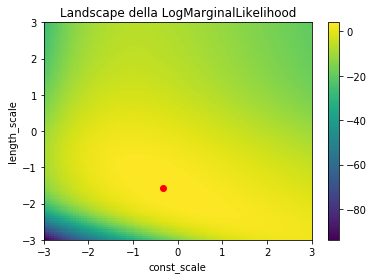

In [63]:
theta0 = np.linspace(-3, 3, 100)
theta1 = np.linspace(-3, 3, 100)

Theta0, Theta1 = np.meshgrid(theta0, theta1)
LML = [[logPosterior([Theta0[i, j], Theta1[i, j], theta[2]], x, t ) for i in range(Theta0.shape[0])] for j in range(Theta1.shape[1])]
LML = np.squeeze(np.array(LML).T)

fig, ax = pl.subplots()
cax = ax.pcolor(theta0, theta1, -LML, cmap=cm.viridis)
vmin, vmax = (-LML).min(), (-LML).max()
fig.colorbar(cax, ax=ax)
pl.plot(theta[0], theta[1], 'ro')
pl.xlabel("const_scale")
pl.ylabel("length_scale")
pl.title("Landscape della LogMarginalLikelihood")

a questo punto definiamo $K$, $K^*$ e $K^{**}$, invertiamo $K$ utilizzando una trasformazione di Cholesky ed utilizziamo le matrici appena trovate per costruire media e varianza della distribuzione condizionata.

In [87]:
k = kernel(x,x,theta,wantderiv=False)
kstar = kernel(xstar,x, theta, wantderiv=False, measnoise=False)
kstarstar = kernel(xstar,xstar,theta,wantderiv=False)
kstarstar_diag = np.diag(kstarstar)

#inversione K
L = np.linalg.cholesky(k)
invk = np.linalg.solve(L.transpose(),np.linalg.solve(L,np.eye(np.shape(x)[0])))

#previsione
mean = np.squeeze(np.dot(kstar,np.dot(invk,t)))
var = kstarstar_diag - np.diag(np.dot(kstar,np.dot(invk,kstar.T)))
var = np.squeeze(np.reshape(var,(n,1)))
s = np.sqrt(var)

possiamo plottare i risultati:

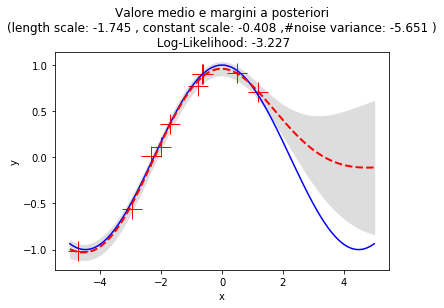

In [88]:
pl.plot(x, t, 'r+', ms=20)
pl.plot(xstar, f(xstar), 'b-')
pl.gca().fill_between(xstar.flat, mean-s, mean+s, color="#dddddd")
pl.plot(xstar, mean, 'r--', lw=2)
pl.title('Valore medio e margini di confidenza')
loglikelihood = logPosterior(theta, x,t)
pl.xlabel('x')
pl.ylabel('y')
title = pl.title('Valore medio e margini a posteriori\n(length scale: %.3f , constant scale: %.3f ,\
#noise variance: %.3f )\n Log-Likelihood: %.3f'
        % (theta[1], theta[0], theta[2], loglikelihood))

possiamo plottare anche alcune estrazioni dalla distribuzione a priori e da quella a posteriori: da notare che il termine di rumore è già inserito all'interno della distribuzione a priori.

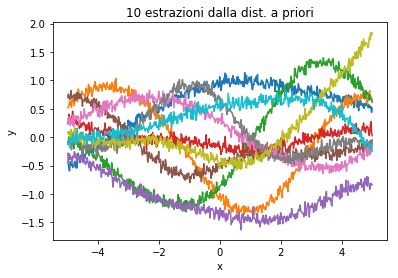

In [95]:
L2 = np.linalg.cholesky(kstarstar + 1e-6*np.eye(n))
#f_prior = mu L*N(0,1)
f_prior = np.dot(L2, np.random.normal(size=(n,10)))
pl.plot(xstar, f_prior)
pl.xlabel('x')
pl.ylabel('y')
title = pl.title('10 estrazioni dalla dist. a priori')

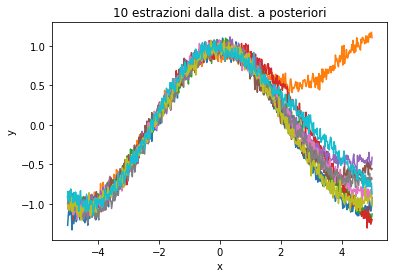

In [96]:
Lk = np.linalg.solve(L, kstar.T)
L2 = np.linalg.cholesky(kstarstar+ 1e-6*np.eye(n) - np.dot(Lk.T, Lk))
#f_post = mu + L*N(0,1)
f_post = mean.reshape(-1,1) + np.dot(L2, np.random.normal(size=(n,10)))
pl.plot(xstar, f_post)
pl.title('10 estrazioni dalla dist. a posteriori')
pl.xlabel('x')
ylab = pl.ylabel('y')